In [19]:
import warnings
warnings.filterwarnings('ignore')

# import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases
from gensim import corpora, models

# import spacy
from spacy.lang.id import Indonesian
nlp = Indonesian()  # use directly
stopwords = spacy.lang.id.stop_words.STOP_WORDS 
stopwords |= {"nya","jurus"}
from json import loads
from ast import literal_eval
from pickle import dump,load

from gensim.models.coherencemodel import CoherenceModel
#show graphs
import matplotlib.pyplot as plt
from gensim import similarities

In [20]:
# #Akronim
def slang(tokenized_sentence):
    slang_word_dict = loads(open("slang_word_dict.txt", 'r').read())

    for index in range(len(tokenized_sentence)):
        for key, value in slang_word_dict.items():
            for v in value:
                if tokenized_sentence[index] == v:
                    tokenized_sentence[index] = key
                else:
                    continue
                    
    return " ".join(tokenized_sentence)

def preprocessing(text):
    text = re.sub('<[^<]+?>', '', str(text)) #remove tag\n",
    text = text.lower() #lower\n",
    text = re.sub(r'[^\w]',' ',str(text)) #remove punct\n",
    text = re.sub(r'\s+', ' ', text) #remove white space\n",
    text = [token.text for token in nlp(text)] #Token
    text = slang(text)#slang word
    text = [token.lemma_ for token in nlp(text) if token.lemma_ not in stopwords] #Lemma & stopword
    
    return text

#function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=500)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [21]:
#Load Clean data
data = pd.read_csv('data_berita_clean.csv')

#Make list of list
mylist = []

for i,j in data.iterrows():
    tmp = literal_eval(j.content)
    mylist.append(tmp)
    
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(mylist, min_count=10)
for idx in range(len(mylist)):
    for token in bigram[mylist[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            mylist[idx].append(token)
    
# Create Dictionary
dictionary = corpora.Dictionary(mylist)

# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in mylist]

dump(corpus, open('corpus_LDA.pkl', 'wb'))
dictionary.save('dictionary_LDA.gensim')

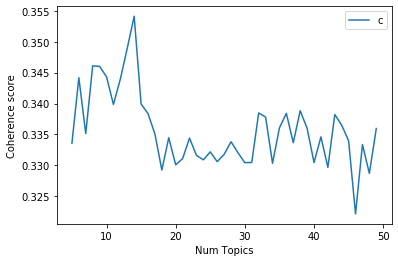

In [4]:
#search optimal topic number (7)
start=5
limit=20
step=1
model_list, coherence_values = compute_coherence_values(dictionary, corpus=corpus, 
                                                        texts=mylist, start=start, limit=limit, step=step)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
# Build LDA model
NUM_TOPICS = 16
lda_model = LdaModel(corpus=corpus,
                    id2word=dictionary,
                    num_topics=NUM_TOPICS, 
                    random_state=666)

#Save Model
lda_model.save('lda.h5')

In [8]:
#Load Mode
loaded_model = LdaModel.load('lda.h5')
test = pd.read_csv('data_berita.csv')
file = open('corpus_LDA.pkl','rb')
loaded_corpus = load(file)

#Test new document
bow = dictionary.doc2bow(preprocessing(test.content.values[109]))
 
print(loaded_model[bow])
 
lda_index = similarities.MatrixSimilarity(loaded_model[loaded_corpus])
 
# # Let's perform some queries
query = lda_index[loaded_model[bow]]
# # Sort the similarities
sort_sim = sorted(enumerate(query), key=lambda item: -item[1])
 
# # Top most similar documents:
print(sort_sim[:10])

# # Let's see what's the most similar document
# document_id, similarity = sort_sim[0]
# print(mylist[document_id][:10])

[(7, 0.16235031), (10, 0.17490803), (15, 0.66024333)]
[(107, 0.99726754), (186, 0.981074), (466, 0.97014505), (283, 0.9668328), (83, 0.9591344), (652, 0.9477138), (30, 0.94661397), (150, 0.945751), (25, 0.9416849), (43, 0.9416849)]


In [23]:
# Print the Keyword in the 10 topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.015*"jurus" + 0.014*"teknik" + 0.010*"ajar" + 0.010*"universitas" + 0.009*"ilmu"')
(1, '0.013*"jurus" + 0.012*"orang" + 0.008*"kerja" + 0.008*"kuliah" + 0.007*"ajar"')
(2, '0.017*"orang" + 0.009*"ajar" + 0.009*"jurus" + 0.006*"teknik" + 0.006*"kerja"')
(3, '0.022*"jurus" + 0.015*"ilmu" + 0.014*"universitas" + 0.009*"teknik" + 0.008*"ajar"')
(4, '0.011*"jurus" + 0.010*"mahasiswa" + 0.010*"universitas" + 0.009*"kuliah" + 0.008*"ajar"')
(5, '0.011*"jurus" + 0.009*"kuliah" + 0.009*"kerja" + 0.009*"orang" + 0.008*"ajar"')
(6, '0.012*"jurus" + 0.011*"ajar" + 0.010*"orang" + 0.007*"bahasa" + 0.007*"ilmu"')
(7, '0.013*"ajar" + 0.009*"mahasiswa" + 0.009*"orang" + 0.009*"jurus" + 0.006*"kuliah"')
(8, '0.013*"orang" + 0.009*"bahasa" + 0.008*"ajar" + 0.006*"kuliah" + 0.006*"kerja"')
(9, '0.010*"orang" + 0.008*"ajar" + 0.007*"sobat" + 0.007*"jurus" + 0.007*"kuliah"')
(10, '0.017*"orang" + 0.011*"kerja" + 0.009*"jurus" + 0.008*"kuliah" + 0.008*"ajar"')
(11, '0.013*"orang" + 0.011*"universitas